In [1]:
import os, shutil, csv,math,scipy,time,joblib
from datetime import datetime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
#displaying data
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow,figure
import matplotlib.image as mpimg
import tifffile as tif
plt.rcParams['figure.dpi'] = 150 
%matplotlib inline
#TF imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from keras import backend as K 
temp_weights=r'D:\Training_Data_Creation\01-logs\temp.h5'
'''TF code to tell TF version, GPU detected, and limit memory growth'''
print(f"Tensorflow ver. {tf.__version__}")
#physical_device = tf.config.experimental.list_physical_devices('GPU')
#print(f'Device found : {physical_device}')
#tf.config.experimental.get_memory_growth(physical_device[0])

Tensorflow ver. 2.8.0


### Loading input tiff and making blank prediction image

In [2]:
input_img=tif.imread(r'E:\GIS\Thesis\Intermediate Data\Large_Imagery\S2_Paper_s4_AOI.tif')

### Loading DNN

In [3]:
def load_model(path):
    '''used to load scikitlearn models'''
    loaded_rf = joblib.load(path)
    print('model loaded')
    return loaded_rf
model = joblib.load(r"D:\Training_Data_Creation\01-logs\RF_reg\RFreg_RF_val1000sqrt-5.529_0.735.joblib")
print('model loaded with weights')

model loaded with weights


### Define output with meaningful name

In [4]:
out_img=r'E:\GIS\Thesis\Intermediate Data\Large_Imagery\s2_s4{}pred_output.tif'.format('RF')

### Displaying blue band and prediction image

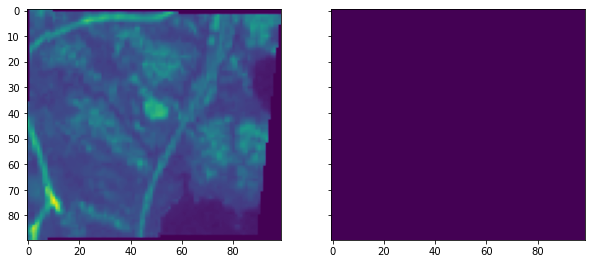

8910 total number of pixels
(90, 99, 9) input shape, (90, 99, 1) output shape


In [5]:
Y_b,X_b,b=input_img.shape
prediction=np.full((Y_b,X_b,1),255,dtype=np.uint8) #creating a prediction image with no data value as default.
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
totalpix=Y_b*X_b
maxpix=input_img[:,:,0].max()
ax[0].imshow(input_img[:,:,0]/maxpix)
ax[1].imshow(prediction/255)
plt.show()
print('{} total number of pixels'.format(totalpix))
print('{} input shape, {} output shape'.format(input_img.shape,prediction.shape))

### Start making prediction image

starting
Final Pixels
Duration: 0:00:01.103000
8202 Pixels processed


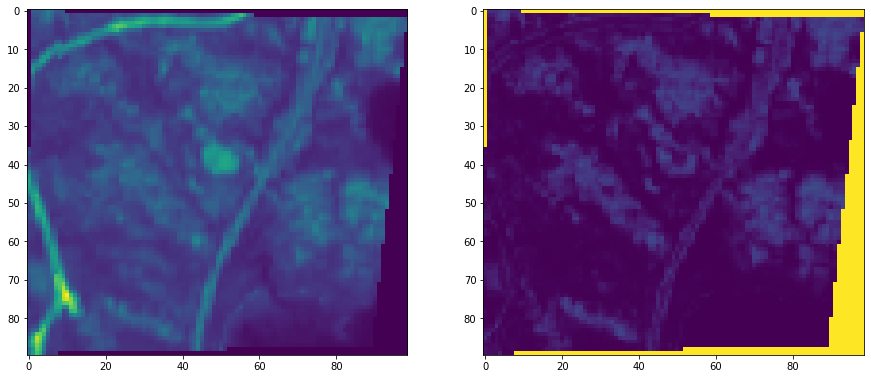

Prediction saved


In [6]:
start_time = datetime.now()
n=0
pred_coord=[]
pred_dataset=[]
print('starting')
for y in range(Y_b): #iterate through all pix
    for x in range(X_b):
        pixel=input_img[y,x] #want to create a tile for initial testing
        if pixel.min() !=0:#make sure there are no null pixels in the rgb raster
            pixel = pixel/65535
            pred_coord.append([y,x])
            pred_dataset.append(pixel)
            n+=1
            if len(pred_dataset) >= 10000: #set number of 000s for how frequently you want to process a batch in tf. #create a tensorflow dataset
                result=model.predict(pred_dataset) #pass the whole dataset throught the model
                for i in range (len(result)): #extract the results and use them to edit 
                    prediction[pred_coord[i][0],pred_coord[i][1]]=result[i]*100
                pred_coord=[]
                pred_dataset=[]#after processing the batch then delete it and start again
            if str(n)[-5:] == '00000':
                ctime_time = (datetime.now()-start_time)
                print('{} pixels processed in {}, {}% done'.format(n,ctime_time,str("%.2f"%(n/totalpix*100))))
print('Final Pixels')
result=model.predict(pred_dataset)
for i in range (len(result)):
    prediction[pred_coord[i][0],pred_coord[i][1]]=result[i]*100
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
print('{} Pixels processed'.format(str(n)))
fig, ax = plt.subplots(1, 2, figsize=(15, 15), sharex=False, sharey=False)
ax[0].imshow(input_img[:,:,2]/3000)
ax[1].imshow(prediction/100)
plt.show()
cv2.imwrite(out_img, prediction)
print('Prediction saved')